In [0]:
#@title Package Installations

!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html 
!pip install fastai
!pip install sklearn
!pip install pyspellchecker

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize



In [0]:
!pip install emot

In [0]:
#@title GPU Maintenance

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

In [0]:
#@title Dependencies
# import libraries 

import fastai 
from fastai import * 
from fastai.text import * 
import pandas as pd 
import numpy as np 

from functools import partial 
import io 
import os
import time
from multiprocessing import  Pool

from google.colab import drive, files

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import gc
import re
import string
import operator
from collections import defaultdict
from wordcloud import STOPWORDS
import re
import itertools

import emot


In [0]:
#@title Mount Google Drive

drive.mount("/content/drive")
%cd 'drive/My Drive/Colab Notebooks/kaggle_disaster_tweets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/kaggle_disaster_tweets'
/content/drive/My Drive/Colab Notebooks/kaggle_disaster_tweets


In [0]:
import helpers as hlp

In [0]:
df_train=pd.read_csv('../kaggle_disaster_tweets/train.csv')
df_test=pd.read_csv('../kaggle_disaster_tweets/test.csv')

In [0]:
df_train = df_train.fillna('')
df_test = df_test.fillna('')

df_train['text'] = df_train['text'].apply(lambda x: hlp.clean_tweet(x))
df_test['text'] = df_test['text'].apply(lambda x: hlp.clean_tweet(x))

In [0]:
#delete hashtag
df_train['text'] = df_train['text'].apply(lambda x: str(x).replace('#', ""))
df_test['text'] = df_test['text'].apply(lambda x: str(x).replace('#', ""))

#delete mention
df_train['text'] = df_train['text'].apply(lambda x: str(x).replace('@', ""))
df_test['text'] = df_test['text'].apply(lambda x: str(x).replace('@', ""))

#delete link
df_train['text'] = df_train['text'].apply(lambda x: hlp.remove_URL(x))
df_test['text'] = df_test['text'].apply(lambda x: hlp.remove_URL(x))

#remove html
df_train['text'] = df_train['text'].apply(lambda x: hlp.remove_html(x))
df_test['text'] = df_test['text'].apply(lambda x: hlp.remove_html(x))

#remove emoji
df_train['text'] = df_train['text'].apply(lambda x: hlp.remove_emoji(x))
df_test['text'] = df_test['text'].apply(lambda x: hlp.remove_emoji(x))

#replace numbers
df_train['text'] = df_train['text'].apply(lambda x: hlp.replace_numbers(x))
df_test['text'] = df_test['text'].apply(lambda x: hlp.replace_numbers(x))


# find emoticons and meanings
df_train['emot'] = df_train['text'].apply(lambda x: hlp.find_emoticon(x))
df_train['emoticon'] = df_train["emot"].apply(lambda x: x.get("value")[0] if x.get("value") else "")
df_train["emotion"] = df_train["emot"].apply(lambda x: x.get("mean")[0] if x.get("mean") else "")

df_test['emot'] = df_test['text'].apply(lambda x: hlp.find_emoticon(x))
df_test['emoticon'] = df_test["emot"].apply(lambda x: x.get("value")[0] if x.get("value") else "")
df_test["emotion"] = df_test["emot"].apply(lambda x: x.get("mean")[0] if x.get("mean") else "")

df_train = df_train.drop(["emot"], axis=1)
df_test = df_test.drop(["emot"], axis=1)



In [0]:
# find text duplicates with conflicting targets and delete
x = df_train.groupby('text' )['target'].apply(lambda x: x.unique()).reset_index()
x = x[x['target'].str.len()>1]['text']

df_train = df_train[df_train['text'].isin(x)==False]

In [0]:
#drop duplicates
df_train = df_train.drop_duplicates(['text', 'target'])

Downsampling

In [0]:
def sampling_k_elements(group, k=len(df_train[df_train['target']==1])):
    return group.sample(k)

#Apply the function
balanced_df = df_train.groupby('target').apply(sampling_k_elements).reset_index(drop=True)
balanced_df['target'].value_counts()

1    3271
0    3271
Name: target, dtype: int64

In [0]:
np.random.seed(123)
df_train = df_train.iloc[np.random.permutation(len(df_train))]

cut1 = int(0.9 * len(df_train)) + 1

df_train_NLP, df_valid_NLP = df_train[:cut1], df_train[cut1:]

ULMFit

In [0]:
data_lm = TextLMDataBunch.from_df(path="", train_df=df_train_NLP, valid_df = df_valid_NLP, text_cols="text", label_cols="target")

In [0]:
data_lm.save('pitchfork_data_lm.pkl')
#data_lm = load_data("/content/drive/My Drive/Colab Notebooks/pitchfork_nlp/", 'pitchfork_data_lm.pkl')

In [0]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 4.37E-04


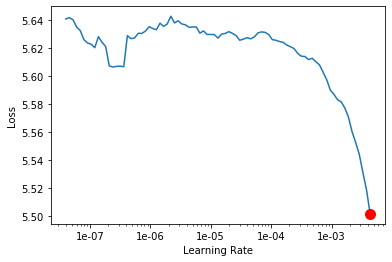

In [0]:
learner.lr_find(start_lr=1e-8, end_lr=1e-2)
learner.recorder.plot(suggestion=True)

In [0]:
learner.fit_one_cycle(cyc_len=8, max_lr=4.37E-04, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.643914,4.429624,0.294688,00:09
1,4.509669,4.264257,0.310089,00:09
2,4.422310,4.237006,0.312455,00:09


In [0]:
learner.unfreeze()
learner.fit_one_cycle(cyc_len=10, max_lr=4.37E-04, moms=(0.9, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.130578,3.817608,0.373750,00:09
1,3.893308,3.599356,0.396920,00:09
2,3.690746,3.442462,0.416161,00:09
3,3.486569,3.336334,0.430045,00:09
4,3.298418,3.265473,0.438795,00:09
5,3.135425,3.223593,0.445714,00:09
6,2.999759,3.196868,0.448080,00:09
7,2.884088,3.190478,0.450714,00:09
8,2.809088,3.186336,0.451920,00:09
9,2.763975,3.186642,0.451518,00:09


In [0]:
learner.save_encoder('tweet_encoder')

In [0]:
data_clas = TextClasDataBunch.from_df(path="", train_df=df_train_NLP, valid_df = df_valid_NLP, test_df=df_test, vocab=data_lm.train_ds.vocab, text_cols="text",label_cols="target", bs=32)

In [0]:
clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
clas.load_encoder('tweet_encoder')
clas.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 1.45E-02


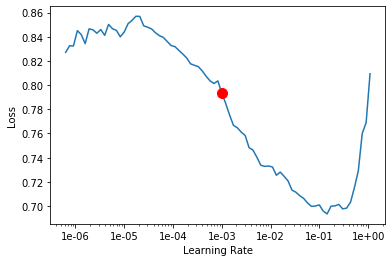

In [0]:
clas.lr_find()
clas.recorder.plot(suggestion = True)

In [0]:
clas.fit_one_cycle(15, 1.45E-02, moms=(0.6, 0.5))

epoch,train_loss,valid_loss,accuracy,time
0,0.467979,0.439207,0.789750,00:09
1,0.483142,0.442592,0.791064,00:10
2,0.478964,0.438475,0.788436,00:10
3,0.504017,0.469651,0.793693,00:11
4,0.483659,0.452319,0.795007,00:10
5,0.483512,0.462384,0.785808,00:10
6,0.495554,0.451610,0.800263,00:09
7,0.477763,0.448377,0.806833,00:10
8,0.470901,0.450078,0.777924,00:10
9,0.479321,0.442432,0.806833,00:10


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.75E-07


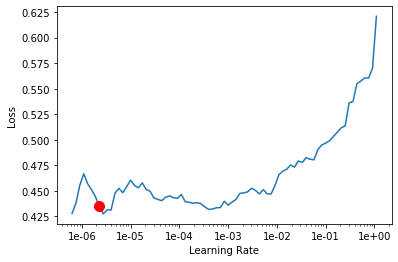

In [0]:
clas.freeze_to(-2)
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [0]:
clas.fit_one_cycle(10, 5.5E-05, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.423455,0.437382,0.808147,00:11
1,0.431734,0.436024,0.802891,00:11
2,0.440749,0.432865,0.804205,00:11


In [0]:
clas.save_encoder('freeze_2_encoder')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.10E-05


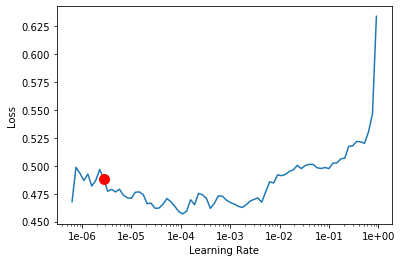

In [0]:
clas.freeze_to(-3)
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [0]:
clas.fit_one_cycle(10, 1.10E-05, moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.444583,0.433996,0.805519,00:10
1,0.454509,0.432471,0.796321,00:10
2,0.443663,0.430686,0.809461,00:10
3,0.420057,0.431410,0.810775,00:11
4,0.442874,0.432556,0.805519,00:10
5,0.434892,0.429172,0.806833,00:11
6,0.417033,0.425698,0.801577,00:11
7,0.423076,0.428607,0.805519,00:11
8,0.413492,0.427143,0.805519,00:11
9,0.429936,0.429548,0.806833,00:11


In [0]:
clas.save_encoder('freeze_3_encoder')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-08


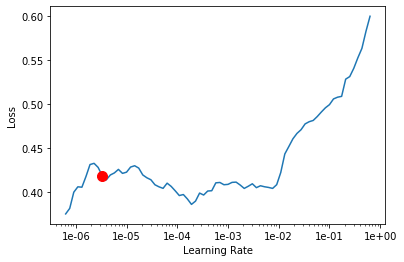

In [0]:
clas.unfreeze()
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [0]:
clas.fit_one_cycle(10, 3.31E-06, moms=(0.98, 0.88))

epoch,train_loss,valid_loss,accuracy,time
0,0.421503,0.427473,0.808147,00:11
1,0.437201,0.426357,0.808147,00:10
2,0.423517,0.427388,0.813403,00:11
3,0.437640,0.425811,0.812089,00:12
4,0.408826,0.429596,0.814717,00:12


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 2.09E-06


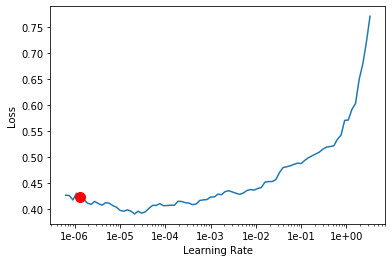

In [0]:
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [0]:
clas.fit_one_cycle(5, 2.09E-06, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.409203,0.425139,0.810775,00:11
1,0.425093,0.423177,0.806833,00:11
2,0.430788,0.423000,0.810775,00:11
3,0.426248,0.424723,0.809461,00:12
4,0.429803,0.430149,0.809461,00:11


In [0]:
nlp_test = pd.DataFrame(clas.get_preds(DatasetType.Test)[0].numpy())

In [0]:
nlp_test_final = np.argmax(np.array(nlp_test), axis=1)

In [0]:
nlp_test_final

array([0, 1, 1, 1, ..., 1, 1, 1, 0])

In [0]:
results = DataFrame()

In [0]:
results['id'] = df_test['id']

In [0]:
results['target'] = nlp_test_final

Create Entry

In [0]:
results.to_csv('ulmfit_more_cycles.csv', index=False)

In [0]:
nlp_test_final

array([0, 1, 1, 1, ..., 1, 1, 1, 0])